# Data Science Capstone Project


#### Importing Libraries Needed

In [2]:
import numpy as np  # library to handle data in a vectorized manner
import pandas as pd  # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json  # library to handle JSON files
from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values
import requests  # library to handle requests
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium  # map rendering library

import json
import pandas as pd

import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## The Problem
I had in my project selected two famous cities of India namely **Delhi** and **Mumbai** for comparison. I will use **Four Square API** to compare the cities.

#### About the datasets
The list of Neighborhoods of both cities have been taken from **Wikipedia**. Later I manually added the *location* coordinates of all neighborhoods and created two **.csv** files for both cities. It was a hectic job but i managed to make it.

In [4]:
df_delhi = pd.read_csv("Specify path to file delhi_city.csv")
df_delhi.head()

,Neighborhood,City,Latitude,Longitude
0,Adarsh Nagar,Delhi,28.719667,77.168752
1,Ashok Vihar,Delhi,28.692035,77.157168
2,Azadpur,Delhi,28.712767,77.167228
3,Bawana,Delhi,28.803035,77.036139
4,Begum Pur,Delhi,28.725592,77.055927


In [89]:
df_mumbai = pd.read_csv("Specify path to file mumbai_city.csv")
df_mumbai.head()

,Neighborhood,City,Latitude,Longitude
0,Andheri,Mumbai,19.114816,72.833471
1,Amboli,Mumbai,19.128048,72.835058
2,Chakala,Mumbai,19.106549,72.850358
3,D.N. Nagar,Mumbai,19.122705,72.821559
4,Four Bungalows,Mumbai,19.121522,72.820787


Lets combine the two dataframes into one.

In [141]:
df = pd.concat([df_delhi,df_mumbai])
df.reset_index(drop = True)
df.rename(columns = {'Neighborhood':'Neighborhood','City':'City','Latitude':'Latitude','Longitude':'Longitude'},inplace = True)
df.head()

,Neighborhood,City,Latitude,Longitude
0,Adarsh Nagar,Delhi,28.719667,77.168752
1,Ashok Vihar,Delhi,28.692035,77.157168
2,Azadpur,Delhi,28.712767,77.167228
3,Bawana,Delhi,28.803035,77.036139
4,Begum Pur,Delhi,28.725592,77.055927


In [752]:
df.columns

Index(['Neighborhood', 'City', 'Latitude', 'Longitude'], dtype='object')

We use **Four Sqaure Api calls** to retrive the Venue Category of each Neighborhood in Delhi.

In [753]:
#CLIENT_ID = 'RZWOHJKE3KHXXL1PNC5VBAF203N3W0NKI1ZIDZQBDLNHZ1H1'  # your Foursquare ID
#CLIENT_SECRET = 'RDZ2X34W55KRTE11XD2SCYBZM0KW0DRXUQQI5RMKKIBLX220'  # your Foursquare Secret
CLIENT_ID = '4CKRRUTQBBBNH1YYSVIGGYFC2N0G4GVZX2RDF054WPGAD15Q'  # your Foursquare ID
CLIENT_SECRET = 'TQDEG5MVHFBKCWQUG5ADSDV2PUVYUKP0CA5VXASUM21VUAWG'  # your Foursquare Secret
VERSION = '20180605'  # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neighborhood_latitude,
    neighborhood_longitude,
    radius,
    LIMIT)
url
results = requests.get(url).json()
#print(results)

Your credentails:
CLIENT_ID: 4CKRRUTQBBBNH1YYSVIGGYFC2N0G4GVZX2RDF054WPGAD15Q
CLIENT_SECRET:TQDEG5MVHFBKCWQUG5ADSDV2PUVYUKP0CA5VXASUM21VUAWG


In [754]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)  # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.head())
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

def getNearbyVenues(names, cities, latitudes, longitudes, radius=500):
    venues_list = []
    for name, city, lat, lng in zip(names, cities, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #print(results)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            city,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'City',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']

    return (nearby_venues)

delhi_mumbai_venues = getNearbyVenues(names=df['Neighborhood'],
                                   cities = df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                   )

print(delhi_mumbai_venues.shape)

                         name          categories        lat        lng
0  Adarsh Nagar Metro Station  Light Rail Station  28.716598  77.170436
1               Axis Bank ATM                 ATM  28.723032  77.170631
2 venues were returned by Foursquare.
Adarsh Nagar
Ashok Vihar
Azadpur
Bawana
Begum Pur
Dhaka
Jahangirpuri
Karala
Keshav Puram
Kingsway Camp
Kohat Enclave
Model Town
Narela
Pitam Pura
Rani Bagh
Rithala
Rohini Sub City
Shalimar Bagh
Shakti Nagar
Bara Hindu Rao
Chandni Chowk
Civil Lines
Dariba Kalan
Gulabi Bagh
Kamla Nagar
Kashmere Gate
Lahori Gate
Nehru Vihar
Paharganj
Pratap Nagar
Pul Bangash
Roshanara Bagh
Sadar Bazaar
Sangam Vihar
Sant Nagar
Sarai Rohilla
Shakti Nagar
Shastri Nagar
Tees Hazari
Timarpur
Wazirabad
Babarpur
Dilshad Garden
Kabir Nagar
Mandoli
Maujpur
Nand Nagri
Naveen Shahdara
New Usmanpur
Sadatpur
Shahdara
SoniVihar
Shastri Park
Yamuna Vihar
Chandni Chowk
Daryaganj
Jhandewalan
Karol Bagh
Bara Hindu Rao
Paharganj
Rajender Nagar
Sadar Bazaar
Barakhamba Road
Ch

To minimize **Four Square Maps Api Calls** we save this Dataframe in a **.csv** file and later retrieve a new dataframe from the same **.csv** file.

In [602]:
#delhi_mumbai_venues.to_csv('/Volumes/Zubair/delhi_mumbai1.csv')

In [101]:
delhi_mumbai_venues = pd.read_csv('/Volumes/Zubair/delhi_mumbai1.csv')
delhi_mumbai_venues = delhi_mumbai_venues.drop(['Unnamed: 0'],axis = 1)
delhi_mumbai_venues.head()

,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,Delhi,28.719667,77.168752,Adarsh Nagar Metro Station,28.716598,77.170436,Light Rail Station
1,Adarsh Nagar,Delhi,28.719667,77.168752,Axis Bank ATM,28.723032,77.170631,ATM
2,Ashok Vihar,Delhi,28.692035,77.157168,Kake Di Hatti | काके दी हट्टी,28.692933,77.152771,Indian Restaurant
3,Ashok Vihar,Delhi,28.692035,77.157168,McDonald's,28.692450,77.152805,Fast Food Restaurant
4,Ashok Vihar,Delhi,28.692035,77.157168,Haldiram,28.692936,77.152878,Indian Restaurant


### Next we extract number of each Individual Venue Categories

In [5]:
both = delhi_mumbai_venues.agg({'Venue Category':'value_counts'})
both.head()

,Venue Category
Indian Restaurant,203
Café,143
Coffee Shop,87
Hotel,68
Fast Food Restaurant,65


We now reset the index of this dataframe

In [6]:
both.reset_index(inplace = True)

After renaming the columns the dataframe looks like this

In [7]:
both = both.rename(columns = {'index':'Venue Category','Venue Category':'No of Venues'})
both.head()

,Venue Category,No of Venues
0,Indian Restaurant,203
1,Café,143
2,Coffee Shop,87
3,Hotel,68
4,Fast Food Restaurant,65


### Next we will extract top 20 Venues from this Dataframe for Comparison

This list will be used to extract top 20 venues from each city later

In [8]:
list1 = both['Venue Category'].tolist()[0:20]
list1

['Indian Restaurant',
 'Café',
 'Coffee Shop',
 'Hotel',
 'Fast Food Restaurant',
 'Restaurant',
 'Chinese Restaurant',
 'Bar',
 'Bakery',
 'Pizza Place',
 'Ice Cream Shop',
 'Dessert Shop',
 'Italian Restaurant',
 'Asian Restaurant',
 'Gym',
 'Sandwich Place',
 'Pub',
 'Park',
 'Market',
 'Snack Place']

Lets use the aggregate function to extract number of venues of each category in both Delhi and Mumbai

In [85]:
delhi_mumbai_agg = delhi_mumbai_venues.groupby(['City']).agg({'Venue Category':'value_counts'})
delhi_mumbai_agg.head()

Venue Category
City  Venue Category                      
Delhi Indian Restaurant                 86
      Café                              77
      Hotel                             49
      Coffee Shop                       38
      Fast Food Restaurant              35

Lets rename the columns and drop the indicies

In [86]:
delhi_mumbai_agg = delhi_mumbai_agg.rename(columns = {'Venue Category':'Number of Venues'})
delhi_mumbai_agg = delhi_mumbai_agg.reset_index(level = ['City','Venue Category'])
delhi_mumbai_agg.head()

,City,Venue Category,Number of Venues
0,Delhi,Indian Restaurant,86
1,Delhi,Café,77
2,Delhi,Hotel,49
3,Delhi,Coffee Shop,38
4,Delhi,Fast Food Restaurant,35


Now we compare each venue in the list with the column 'Venue Category' and create a new dataframe with only top 20 venues in each city

In [11]:
top_10 = delhi_mumbai_agg[delhi_mumbai_agg['Venue Category'].isin(list1)]
top_10.reset_index(inplace = True)
top_10.drop(columns = ['index'],inplace = True)
top_10.head()

/Users/mac/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,City,Venue Category,Number of Venues
0,Delhi,Indian Restaurant,86
1,Delhi,Café,77
2,Delhi,Hotel,49
3,Delhi,Coffee Shop,38
4,Delhi,Fast Food Restaurant,35


Lets create two individual dataframes one for each Delhi and Mumbai

In [12]:
delhi_df = top_10[0:20]
mumbai_df = top_10[20:40]
df_compare_top10 = delhi_df
df_compare_top10

,City,Venue Category,Number of Venues
0,Delhi,Indian Restaurant,86
1,Delhi,Café,77
2,Delhi,Hotel,49
3,Delhi,Coffee Shop,38
4,Delhi,Fast Food Restaurant,35
5,Delhi,Restaurant,28
6,Delhi,Bakery,27
7,Delhi,Market,26
8,Delhi,Bar,24
9,Delhi,Pizza Place,23


We created the above additional dataframe for visualization.<br />
Next we add two columns each giving Number of Venues for each category in both cities.<br />
Here is how we populate that

In [13]:
df_compare_top10['Delhi Venues'] = np.where(delhi_df['City']=='Delhi', delhi_df['Number of Venues'], 'no')
df_compare_top10['Mumbai Venues'] = np.where(mumbai_df['City']=='Mumbai', mumbai_df['Number of Venues'], 'no')
df_compare_top10 = df_compare_top10.drop(['City','Number of Venues'],axis=1)
df_compare_top10.set_index(['Venue Category'],inplace = True)
df_compare_top10.head()

/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Delhi Venues,Mumbai Venues
Venue Category,,
Indian Restaurant,86,117
Café,77,66
Hotel,49,49
Coffee Shop,38,35
Fast Food Restaurant,35,34


In [14]:
df_compare_top10.columns

Index(['Delhi Venues', 'Mumbai Venues'], dtype='object')

Note : Its important to covert the numbers to numeric for input to matplot

In [15]:
df_compare_top10['Delhi Venues']=pd.to_numeric(df_compare_top10['Delhi Venues'])
df_compare_top10['Mumbai Venues']=pd.to_numeric(df_compare_top10['Mumbai Venues'])

### Now lets finally plot the Values using a bar Graph

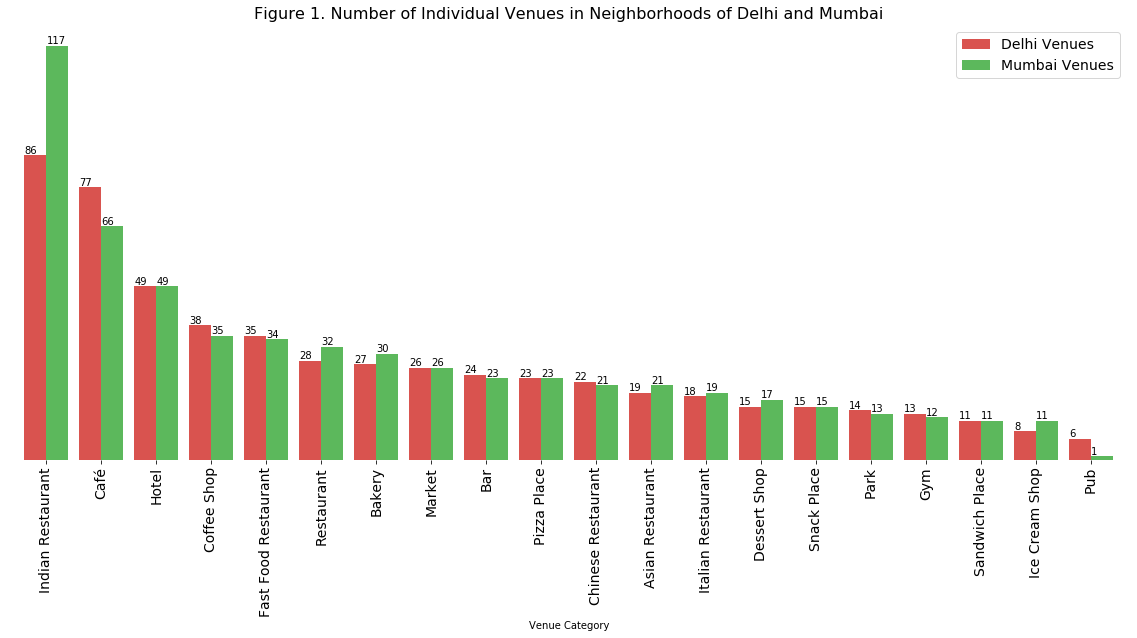

In [16]:
colors_list = ['#d9534f','#5cb85c']

# Change this line to plot percentages instead of absolute values
ax = df_compare_top10.plot(kind='bar',figsize=(20,8),width = 0.8,color = colors_list,edgecolor=None)
plt.legend(labels=df_compare_top10.columns,fontsize= 14)
plt.title("Figure 1. Number of Individual Venues in Neighborhoods of Delhi and Mumbai",fontsize= 16)


plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:}'.format(height), (x, y + height + 0.50))


##### From the above figure we can infer the following findings:<br />
    1. There are more Indian Restaurants in both Delhi and Mumbai followed by Cafe as expected.
    2. The highest amoung venue categories are restaurants which include Indian Restaurants, Restaurants, Fast          Food Restaurant and Chinese Restaurant.
    3. There are more Indian Restaurants in Mumbai than in Delhi.
    4. There are more Cafe in Delhi than in Mumbai.
    5. The hotels are equal in number in both cities.
    6. Delhi being the capital has more number of Chinese Restaurants than Mumbai.
    7. There are more Ice Cream Shops in Mumbai than in Delhi and that may be due to the Harsh Winters of Delhi.
    8. There are more centeres of Gym in Delhi than in Mumbai.
    9. One most imporant assumption that we could make is that based on Venue Categories Delhi and Mumbai are a lot similar.

## 2. Comparing individual Neighbourhood

Now we consider Neighborhoods of each individual City.<br /> 
For this we will try  to extract common venues of both cities. Here we star with Delhi. We will create a Dataframe that consists of top ten most common venues.

In [17]:
delhi_mumbai_venues.head()

,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,Delhi,28.719667,77.168752,Adarsh Nagar Metro Station,28.716598,77.170436,Light Rail Station
1,Adarsh Nagar,Delhi,28.719667,77.168752,Axis Bank ATM,28.723032,77.170631,ATM
2,Ashok Vihar,Delhi,28.692035,77.157168,Kake Di Hatti | काके दी हट्टी,28.692933,77.152771,Indian Restaurant
3,Ashok Vihar,Delhi,28.692035,77.157168,McDonald's,28.692450,77.152805,Fast Food Restaurant
4,Ashok Vihar,Delhi,28.692035,77.157168,Haldiram,28.692936,77.152878,Indian Restaurant


Now we perform One Hot Encoding

In [18]:
# one hot encoding
delhi_mumbai_onehot = pd.get_dummies(delhi_mumbai_venues[['Venue Category']], prefix="", prefix_sep="")
# print(manhattan_onehot)
# add neighborhood column back to dataframe
delhi_mumbai_onehot['City']        = delhi_mumbai_venues['City']
delhi_mumbai_onehot['Neighbourhood'] = delhi_mumbai_venues['Neighborhood']
# move neighborhood column to the first column

fixed_columns = [delhi_mumbai_onehot.columns[-1]] +[delhi_mumbai_onehot.columns[-2]] + list(delhi_mumbai_onehot.columns[:-2])
delhi_mumbai_onehot = delhi_mumbai_onehot[fixed_columns]
delhi_mumbai_onehot.head()


,Neighbourhood,City,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Business Service,Cafeteria,Café,Campground,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Gym,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irani Cafe,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Office,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,RV Park,Racetrack,Recreation Center,Rental Car Location,Rental Service,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Tapas Restaurant,Tea Room,Theater,Theme Park,Tibetan Restaurant,Tourist Information Center,Track,Train Station,Travel Agency,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Shop,Women's Store
0,Adarsh Nagar,Delhi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,Delhi,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [19]:
delhi_mumbai_grouped = delhi_mumbai_onehot.groupby(['Neighbourhood','City']).mean().reset_index()
delhi_mumbai_grouped.head()
#delhi_grouped.shape

num_top_venues = 5

for hood , state in zip(delhi_mumbai_grouped['Neighbourhood'],delhi_mumbai_grouped['City']):
    #print("----" + hood + "----")
    temp = delhi_mumbai_grouped[delhi_mumbai_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')
delhi_mumbai_grouped.head()

,Neighbourhood,City,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Business Service,Cafeteria,Café,Campground,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Gym,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irani Cafe,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Office,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,RV Park,Racetrack,Recreation Center,Rental Car Location,Rental Service,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Tapas Restaurant,Tea Room,Theater,Theme Park,Tibetan Restaurant,Tourist Information Center,Track,Train Station,Travel Agency,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Shop,Women's Store
0,Aareyr Milk Colony,Mumbai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0

In [20]:
delhi_mumbai_grouped.shape

(246, 226)

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]



num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood','City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = delhi_mumbai_grouped['Neighbourhood']
neighborhoods_venues_sorted['City'] = delhi_mumbai_grouped['City']
for ind in np.arange(delhi_mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(delhi_mumbai_grouped.iloc[ind, 1:],num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aareyr Milk Colony,Mumbai,Mountain,Women's Store,IT Services,Food & Drink Shop,Food
1,Adarsh Nagar,Delhi,ATM,Light Rail Station,Food Truck,Food & Drink Shop,Food
2,Alaknanda,Delhi,Gym,Indian Restaurant,Boutique,Spa,RV Park
3,Amboli,Mumbai,Pub,Indian Restaurant,Bar,Lounge,Pizza Place
4,Amrut Nagar,Mumbai,Park,Mobile Phone Shop,Women's Store,Event Space,Food & Drink Shop


In [62]:
neighborhoods_venues_sorted.shape

(246, 7)

Now we refine this first to select all Neighborhoods of Delhi later we will do the same for Mumbai neighbourhoods.

In [63]:
delhi_neighborhoods = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['City'] == 'Delhi']
delhi_neighborhoods

,Neighbourhood,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Adarsh Nagar,Delhi,ATM,Light Rail Station,Food Truck,Food & Drink Shop,Food
2,Alaknanda,Delhi,Gym,Indian Restaurant,Boutique,Spa,RV Park
5,Anand Vihar,Delhi,Pharmacy,Pizza Place,Market,Spa,Bakery
9,Ashok Nagar,Delhi,Restaurant,Clothing Store,Café,Department Store,South Indian Restaurant
10,Ashok Vihar,Delhi,Indian Restaurant,Tea Room,Fast Food Restaurant,Women's Store,Food & Drink Shop
11,Azadpur,Delhi,Train Station,Women's Store,Electronics Store,Food & Drink Shop,Food
12,Babarpur,Delhi,ATM,IT Services,Motorcycle Shop,Food & Drink Shop,Food
14,Badarpur,Delhi,ATM,Wine Shop,Food Court,Food & Drink Shop,Food
15,Bali Nagar,Delhi,Shopping Mall,American Restaurant,Multiplex,Event Space,Food Court
20,Bara Hindu Rao,Delhi,Train Station,Women's Store,Electronics Store,Food & Drink Shop,Food


In [64]:
delhi_neighborhoods.shape

(150, 7)

Next we calculate the percentage values of **1st most Common Venues** and select the top 20 for comparison.  

In [65]:
delhi_agg_1venue = delhi_neighborhoods.groupby(['City']).agg({'1st Most Common Venue':'value_counts'})
delhi_agg_1venue['1st Most Common Venue'] = (delhi_agg_1venue['1st Most Common Venue'] /delhi_neighborhoods.shape[0] * 100)
delhi_agg_1venue = delhi_agg_1venue[0:20]
delhi_agg_1venue.head()

1st Most Common Venue
City  1st Most Common Venue                       
Delhi Indian Restaurant                  15.333333
      Café                                8.000000
      ATM                                 7.333333
      Hotel                               6.666667
      Pizza Place                         6.000000

We need to convert *1st most Common Venues* column values to numeric values.

In [66]:
delhi_agg_1venue['1st Most Common Venue']=pd.to_numeric(delhi_agg_1venue['1st Most Common Venue'])

Lets plot the values for visualization.

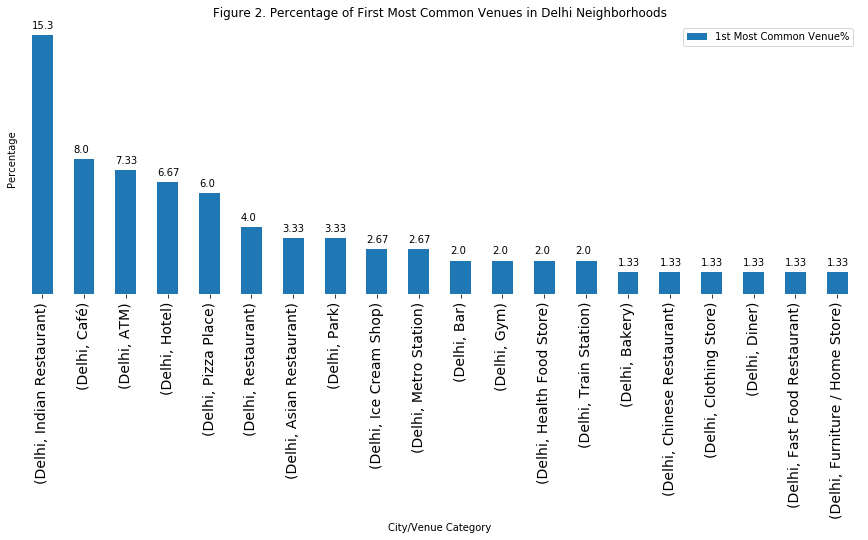

In [67]:
ax = delhi_agg_1venue.plot(kind = 'bar',width = 0.5,figsize = (15,5),edgecolor=None)
plt.legend(labels=delhi_agg_1venue.columns + '%',fontsize= 10)
plt.title("Figure 2. Percentage of First Most Common Venues in Delhi Neighborhoods",fontsize= 12)
plt.xlabel('City/Venue Category')
plt.ylabel('Percentage')

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.3}'.format(height), (x, y + height + 0.40))

### From the above figure we can infer that 
1.There are about **15%** Neighborhoods in delhi which have *'Indian Restaurants'* as their 1st Most common place.<br /> 
2.Similarly about **8%** of Neighborhoods have *'Cafe'* as their 1st most common venue.<br />
3.Other most important interpretation is that even though in **Figure 1** the third ranked venue category is *'Hotel'* but as we see in **Figure 2** the third ranked venue category is *'ATM'* with a percentage value of **7.33** which indicates that *ATM's* in Delhi Neighborhoods are located close to each other than that of *Hotels* being close to each other.<br />
4.Also **pizza places** are close to each other than *Coffee Shops, Restaurants, Bakery, Market and Bars being close to each other*.<br />
5.**Fast Food Restaurants** are widely distributed in *Delhi Neighborhoods*.

### Locations where business can be setup in Delhi.
Now we will try to find out locations where certain business can be set up. We define the criteria of selection based on the absence of that particular venue category in a particular neighborhood. We take locations where a particular venue category is not common.

Let's look for **Indian Restaurants** in Delhi

In [138]:
delhi_indian_restaurants = delhi_neighborhoods.loc[\
                        (delhi_neighborhoods['1st Most Common Venue'] != 'Indian Restaurant')\
                        & (delhi_neighborhoods['2nd Most Common Venue'] != 'Indian Restaurant')\
                        & (delhi_neighborhoods['3rd Most Common Venue'] != 'Indian Restaurant')\
                        & (delhi_neighborhoods['4th Most Common Venue'] != 'Indian Restaurant')\
                        & (delhi_neighborhoods['5th Most Common Venue'] != 'Indian Restaurant')]
indian_restaurants_delhi = delhi_indian_restaurants['Neighbourhood']
indian_restaurants_delhi.tolist()
delhi_indian_restaurants.shape

(112, 7)

So we can say that if someone is to open an *Indian Restaurant* in *Delhi City* it is feasible to select out of these **112 Neighborhoods** a location as this Venue Category is absent in these locations.

Next we look for **Cafes** in *Delhi*.

In [139]:
delhi_indian_cafes = delhi_neighborhoods.loc[\
                        (delhi_neighborhoods['1st Most Common Venue'] != 'Café')\
                        & (delhi_neighborhoods['2nd Most Common Venue'] != 'Café')\
                        & (delhi_neighborhoods['3rd Most Common Venue'] != 'Café')\
                        & (delhi_neighborhoods['4th Most Common Venue'] != 'Café')\
                        & (delhi_neighborhoods['5th Most Common Venue'] != 'Café')]
indian_cafes_delhi = delhi_indian_cafes['Neighbourhood']
indian_cafes_delhi.tolist()
delhi_indian_cafes.shape

(117, 7)

## Lets repeat the same process for **Mumbai City Neighborhoods**.

In [132]:
mumbai_neighborhoods = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['City'] == 'Mumbai']
mumbai_neighborhoods.head()

,Neighbourhood,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aareyr Milk Colony,Mumbai,Mountain,Women's Store,IT Services,Food & Drink Shop,Food
3,Amboli,Mumbai,Pub,Indian Restaurant,Bar,Lounge,Pizza Place
4,Amrut Nagar,Mumbai,Park,Mobile Phone Shop,Women's Store,Event Space,Food & Drink Shop
6,Andheri,Mumbai,Indian Restaurant,Coffee Shop,Pub,Café,Women's Store
7,Antop Hill,Mumbai,Indian Restaurant,Pizza Place,Punjabi Restaurant,Train Station,Women's Store


In [133]:
mumbai_neighborhoods.shape

(95, 7)

In [134]:
mumbai_agg_1venue = mumbai_neighborhoods.groupby(['City']).agg({'1st Most Common Venue':'value_counts'})
mumbai_agg_1venue['1st Most Common Venue'] = (mumbai_agg_1venue['1st Most Common Venue'] /mumbai_neighborhoods.shape[0] * 100)
mumbai_agg_1venue = mumbai_agg_1venue[0:20]

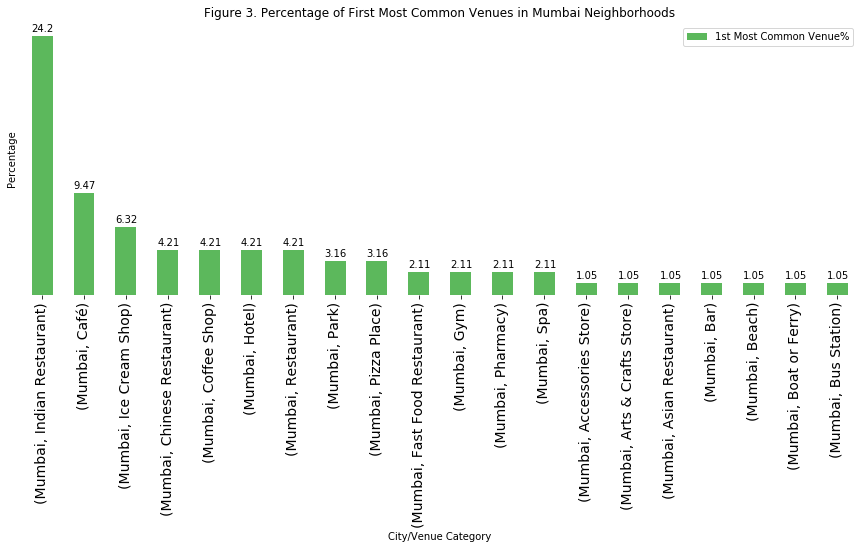

In [128]:
colors_list = ['#5cb85c']
ax = mumbai_agg_1venue.plot(kind = 'bar',figsize = (15,5),color = colors_list)
plt.legend(labels=mumbai_agg_1venue.columns + '%',fontsize= 10)
plt.title("Figure 3. Percentage of First Most Common Venues in Mumbai Neighborhoods",fontsize= 12)
plt.xlabel('City/Venue Category')
plt.ylabel('Percentage')

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:0.3}'.format(height), (x, y + height + 0.40))

### From the above figure we can infer that 
1.There are about **24%** Neighborhoods in delhi which have **'Indian Restaurants'** as their 1st Most common place.<br />
2.Similarly about **9%** of Neighborhoods have **'Cafe'** as their 1st most common venue.<br />
3.Other most important interpretation is that even though in **Figure 1** the third ranked venue category is *'Hotel'* but as we see in **Figure 3** the third ranked venue category is *Ice Cream Shops* with a percentage value of **6.32** which indicates that Ice Cream Shops in Mumbai Neighborhoods are located too close to each other than that of hotels being close to each other.<br />
4.**Coffee  Shops** are almost evenly distributed in Mumbai Neighborhoods.<br />
5.Also **Chinese Restaurants** are close to each other than *Hotels, Coffee Shops, Restaurants, Bakery, Market, Pizza Places and Bars*.<br />
6.**Bars** are widely distributed in Mumbai Neighborhoods.<br />
7.Also **Chinese Restaurants** in *Mumbai Neighborhoods* are in close proximity than that in *Delhi Neighborhoods*.<br />

### Locations where business can be setup in Mumbai.
Now we will try to find out locations where certain business can be set up. We define the criteria of selection based on the absence of that particular venue category in a particular neighborhood. We take locations where a particular venue category is not common.

Let's look for **Indian Restaurants** in Mumbai

In [142]:
mumbai_indian_restaurants = mumbai_neighborhoods.loc[\
                        (mumbai_neighborhoods['1st Most Common Venue'] != 'Indian Restaurant')\
                        & (mumbai_neighborhoods['2nd Most Common Venue'] != 'Indian Restaurant')\
                        & (mumbai_neighborhoods['3rd Most Common Venue'] != 'Indian Restaurant')\
                        & (mumbai_neighborhoods['4th Most Common Venue'] != 'Indian Restaurant')\
                        & (mumbai_neighborhoods['5th Most Common Venue'] != 'Indian Restaurant')]
indian_restaurants_mumbai = mumbai_indian_restaurants['Neighbourhood']
indian_restaurants_mumbai.tolist()
mumbai_indian_restaurants.shape

(52, 7)

So we can say that if someone is to open an *Indian Restaurant* in *Mumbai city* it is feasible to select out of these **52 Neighborhoods** a location as this Venue Category is absent in these locations.

Next we look for **Cafes** in *Delhi*.

In [137]:
mumbai_indian_cafes = mumbai_neighborhoods.loc[\
                        (mumbai_neighborhoods['1st Most Common Venue'] != 'Café')\
                        & (mumbai_neighborhoods['2nd Most Common Venue'] != 'Café')\
                        & (mumbai_neighborhoods['3rd Most Common Venue'] != 'Café')\
                        & (mumbai_neighborhoods['4th Most Common Venue'] != 'Café')\
                        & (mumbai_neighborhoods['5th Most Common Venue'] != 'Café')]
indian_cafes_mumbai = mumbai_indian_cafes['Neighbourhood']
indian_cafes_mumbai.tolist()
mumbai_indian_cafes.shape

(72, 7)

### Thank You for your Patience 